## CONTENTS

1. [Imports](#Imports)
2. [Assumptions](#Assumptions)
3. [Modelling](#Modelling)
   - [Algorithm Selection](#Algorithm-Selection)
   - [Data Preparation](#Data-Preparation)
4. [Training](#Training)
5. [Metrics](#Metrics)
6. [Predictions](#Predictions-on-Test-Data)

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

In [65]:
import pathlib
import os
import sys

import pandas as pd
import numpy as np

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    log_loss,
)

import xgboost as xgb
import lightgbm as lgb
import catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns


import optuna

In [4]:
sys.path.append(str(pathlib.Path(os.getcwd()).resolve().parent))

In [308]:
from config import config
from src import utils
from src.preprocessing import preprocessors, pipelines
from src.models import parameter_tuning

# Assumptions 

- There does not exist any ordinal relationship in the numeric encodings for the data.

# Modelling

### Algorithm Selection

To model the click prediction problem, the following tree based boosting algorithms were experimented with :- 
- XGBoost
- CatBoost
- LightGBM

In the end, the XGBoost algorithm was chosen for fitting the final model. 

Since the dataset is heavily imbalanced, accuracy is not a good metric to evaluate model performance. F1 score, which is a harmonic combination of precision and recall scores, serves as as much better metric for performance, along with the ROC - AUC Curve.  

### Data Preparation

Reading in the train and test data files created in **Data Extraction** Notebook.

In [335]:
train_data = pd.read_parquet(config.TRAIN_DATASET_RAW)
test_data = pd.read_parquet(config.TEST_DATASET_RAW)

Since all the features are categorical, 

In [337]:
train_data.click.value_counts(normalize=True)

0    0.900574
1    0.099426
Name: click, dtype: float64

In [338]:
# stratified train test split
X_train, X_valid, y_train, y_valid = train_test_split(
    train_data.drop(columns="click"),
    train_data["click"],
    shuffle=True,
    random_state=config.SEED,
    stratify=train_data["click"],
)

In [339]:
y_train.value_counts(normalize=True)

0    0.90057
1    0.09943
Name: click, dtype: float64

Since the dataset is heavily imbalanced (~90 % of labels in the training dataset are class **0**),any ML model fit over the untreated dataset will lead to perform poorly on the minority class. To address this challenge, following approaches were considered.

- SMOTE (Synthetic Minority Oversampling Technique), which looks to balance the dataset by generating synthetic datapoints for the minority class. Since the dataset is composed of all categorical features, a variant of SMOTE, [SMOTEN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html) would be appropriate for data augmentation. 
- Random Undersampling of the minority class, wherein only a fraction of all the majority class datapoints are dropped in order to improve the ratio of classes labels. 
- Assigning differential class weights to majority and minority class samples, such that misclassifying a minority class datapoint accrues higher penalty as compared to misclassifying a majority class datapoint. 

After experimenting with the approaches listed above, a combination of Random Undersampling + Scaling Positive Class Weights approaches were used to ameliorate the effects of class imbalance.

In [340]:
pos_idx = y_train[y_train == 1].index
neg_idx = y_train[y_train == 0].sample(frac=0.2, random_state=config.SEED).index

X_train_pos = X_train.loc[pos_idx, :]
X_train_neg = X_train.loc[neg_idx, :]

X_train_pos[config.TARGET] = y_train[pos_idx]
X_train_neg[config.TARGET] = y_train[neg_idx]

comb = pd.concat([X_train_pos, X_train_neg]).sample(frac=1).reset_index()

X_train, y_train = comb[config.FEATURES], comb[config.TARGET]

In [341]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((17327, 19), (20661, 19), (17327,), (20661,))

In [342]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

Saving the train and valid files in the **/data/final** folder

In [343]:
X_train.to_csv(config.X_TRAIN, index=False)
y_train.to_csv(config.Y_TRAIN, index=False)
X_valid.to_csv(config.X_VALID, index=False)
y_valid.to_csv(config.Y_VALID, index=False)

After retaining only 20% of the class **0** records, and a 100% of all class **1** records in the trianing dataset, the following distirbution for class labels in the training dataset is noted

In [344]:
y_train.value_counts(normalize=True)

0    0.644312
1    0.355688
Name: click, dtype: float64

The Scale factor for class **1** datapoints is set to the ratio of # class **0** datapoints in train to the # class **1** datapoints in train

In [374]:
weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
weight

1.811455460003245

# Training

In [375]:
pipeline = pipelines.get_pipeline(params)

In [377]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('categorical_encoding',
                 CategoricalTransformer(columns=['hash_0', 'hash_1', 'hash_2',
                                                 'hash_3', 'hash_4', 'hash_5',
                                                 'hash_6', 'hash_7', 'hash_8',
                                                 'hash_9', 'hash_10', 'hash_11',
                                                 'hash_12', 'hash_13',
                                                 'hash_14', 'hash_15',
                                                 'hash_16', 'hash_17',
                                                 'hash_18'])),
                ('categorical_mapping',
                 CategoricalMapper(columns=['hash_0', 'hash_1', 'hash_2',
                                            'hash_3', 'hash_4',...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.029831684879606152, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=81, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [378]:
preds = pipeline.predict(X_valid)
preds_proba = pipeline.predict_proba(X_valid)

# Metrics

### Accuracy Score on Validation Dataset

In [364]:
accuracy_score(y_valid, preds)

0.7638062049271575

### ROC - AUC Score on Validation Dataset

In [365]:
roc_auc_score(y_valid, [x[1] for x in preds_proba])

0.7985612726811935

### 5 Fold Stratified CV accuracy score on the training set

In [366]:
%%time 
x = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')

np.mean(x)

CPU times: user 4.91 s, sys: 19.7 ms, total: 4.93 s
Wall time: 2.82 s


0.7229179271071943

### 5 Fold Stratified CV ROC-AUC score on the training set

In [367]:
%%time 
x = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='roc_auc')

np.mean(x)

CPU times: user 5 s, sys: 0 ns, total: 5 s
Wall time: 2.83 s


0.78325169593846

### 5 Fold Stratified CV F1 score on the training set

In [368]:
%%time 
x = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1')

np.mean(x)

CPU times: user 5.68 s, sys: 19.6 ms, total: 5.69 s
Wall time: 3.53 s


0.6232140605782204

# Feature Importance

<AxesSubplot:>

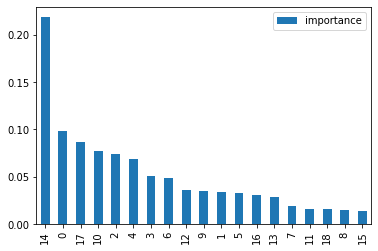

In [384]:
pd.DataFrame(
    {"feature": X_train.columns, "importance": pipeline[3].feature_importances_}
).sort_values("importance", ascending=False).plot(kind="bar")

# Predictions on Test Data

In [369]:
preds = pipeline.predict_proba(test_data)

In [370]:
test_data["prediction"] = [p[1] for p in preds]

In [371]:
test_data.to_csv(config.FINAL_DATASET)

# Notes and Suggested Improvements. 

- The Target Encoder used in the final pipeline was trained over the entire training dataset, an approach that is prone to overfitting. A better way to get encoded labels is using OOF prediction in a stratified KFold scheme to avoid overfitting on the training data. This will result in K encodings for each feature, which can then be averaged out to get a single encoding per category. 
- Additional experiments around combining SMOTEN , Majority Undersampling and scaled positive class weights could yield better results. 
- A Tabular NN based approach, where each feature is embedded in a high dimensional vector space and the final targets learnt using  Cross Entory could also yield better results for this problem.